# EDA: Sychrony detection for classroom activities

File: 'core_classroom_analysis.py'

Checkpoint: 1

## Load data

In [53]:
pkl_filepath = '/home/wang159/nanoHUB/projects/online_users_ts_analysis/temp/core_classroom_analysis_cp1.pkl'

In [54]:
from pprint import pprint
import pandas as pd
import numpy as np
import datetime

from dask import dataframe as dd
from dask.multiprocessing import get
from dask.diagnostics import ProgressBar

pbar = ProgressBar()
pbar.register()

In [55]:
# Load checkpoint shelve
import pickle
with open(pkl_filepath, 'rb') as f:
    inparams = pickle.load(f)

user_activity_blocks_df = pd.read_pickle('/home/wang159/nanoHUB/projects/online_users_ts_analysis/temp/cp1_user_activity_blocks_df.pkl')
jos_users = pd.read_pickle('/home/wang159/nanoHUB/projects/online_users_ts_analysis/temp/cp1_jos_users.pkl')
toolrun_df = pd.read_pickle('/home/wang159/nanoHUB/projects/online_users_ts_analysis/temp/cp1_toolrun_df.pkl')
cluster_output_candidate = pd.read_pickle('/home/wang159/nanoHUB/projects/online_users_ts_analysis/temp/cp1_cluster_output_candidate.pkl')
detected_clusters_df = pd.read_pickle('/home/wang159/nanoHUB/projects/online_users_ts_analysis/temp/cp1_detected_clusters_df.pkl')

cluster_post_sychrony = pd.read_pickle('/home/wang159/nanoHUB/projects/online_users_ts_analysis/temp/cp1_cluster_post_sychrony.pkl')        

In [56]:
cluster_post_sychrony

,user,tool,start,end,ip,lon,lat,cluster,scanned_date,user_meet_class_size_min,DBSCAN
0,erikaaileen,geneticalgo,2013-09-11,2013-09-15,128.210.86.192,-86.9147,40.4251,0,2013-09-13,True,0
1,kfish105,geneticalgo,2013-09-11,2013-09-15,98.223.100.12,-86.9256,40.4444,0,2013-09-13,True,0
2,caitlinr23,geneticalgo,2013-09-10,2013-09-14,98.223.109.85,-86.9256,40.4444,0,2013-09-13,True,0
3,poji,geneticalgo,2013-09-10,2013-09-14,128.46.103.33,-86.9147,40.4251,0,2013-09-13,True,0
4,cbarringer,geneticalgo,2013-09-13,2013-09-17,128.211.199.17,-86.9147,40.4251,0,2013-09-13,True,0
...,...,...,...,...,...,...,...,...,...,...,...
880755,tshivam4,workspace,2019-08-11,2019-08-24,67.163.5.48,-86.9256,40.4444,3,2019-08-19,True,0
880756,desai61,workspace,2019-08-16,2019-08-21,98.223.106.98,-86.9256,40.4444,2,2019-08-20,True,0
880757,jverduzc,workspace,2019-08-16,2019-08-20,66.253.158.24,-86.9256,40.4444,2,2019-08-20,True,0
880758,mmh,workspace,2019-08-18,2019-08-22,128.46.16.10,-86.9147,40.4251,2,2019-08-20,True,0


## Form super-clusters by merging individual clusters

In [57]:
def user_to_group_clusters(user_group, min_size):
    '''
    Form a group clusters from individual user activity blocks
    '''
    
    # remove group clusters that are smaller than minimal size
    if user_group.shape[0] < min_size:
        return None
    
    user_set = user_group.user.unique()
    ip_set = user_group.ip.unique()
    mean_lon = user_group.lon.mean()
    mean_lat = user_group.lat.mean()
    #return pd.DataFrame([set(user_set), mean_lon, mean_lat], columns=['user_set', 'mean_lon', 'mean_lat'])    
    return pd.DataFrame([[set(user_set), mean_lon, mean_lat, set(ip_set)]], columns=['user_set', 'mean_lon', 'mean_lat', 'ip_set'])
    
    

In [58]:
# transform individual user's clusters into group cluster identified by scanned_date, tool, cluster, and DBSCAN
group_clusters = cluster_post_sychrony.groupby(['tool', 'cluster', 'scanned_date','DBSCAN']) \
                                      .apply(user_to_group_clusters, min_size=inparams[0].class_size_min) \
                                      .reset_index()
    
# series containing each group cluster in rows
#group_clusters = group_clusters.rename('group').to_frame()

display(group_clusters)

,tool,cluster,scanned_date,DBSCAN,level_4,user_set,mean_lon,mean_lat,ip_set
0,1dchainmd,0,2013-09-01,0,0,"{purdueme, zufeltk, gw014425, cohn678, kshare0...",-86.787500,36.168500,"{129.59.115.4, 129.59.79.179, 98.240.94.25, 12..."
1,1dchainmd,0,2013-09-02,0,0,"{purdueme, zufeltk, gw014425, cohn678, kshare0...",-86.787500,36.168500,"{129.59.115.4, 129.59.79.179, 98.240.94.25, 12..."
2,1dchainmd,0,2013-09-03,0,0,"{purdueme, zufeltk, gw014425, cohn678, kshare0...",-86.787500,36.168500,"{129.59.115.4, 129.59.79.179, 98.240.94.25, 12..."
3,1dchainmd,0,2013-09-04,0,0,"{purdueme, zufeltk, gw014425, cohn678, kshare0...",-86.787500,36.168500,"{129.59.115.4, 129.59.79.179, 98.240.94.25, 12..."
4,1dchainmd,0,2013-09-05,0,0,"{zufeltk, gw014425, cohn678, kshare01, carterr...",-86.786857,36.170929,"{129.59.115.4, 129.59.79.179, 98.240.94.25, 12..."
...,...,...,...,...,...,...,...,...,...
51999,wulffman,3,2015-10-03,0,0,"{alicia.cintora, kevinf92, mp868, zl453, ablan...",-76.483700,42.447400,"{128.84.125.249, 128.84.244.168, 128.84.125.12..."
52000,wulffman,4,2015-09-15,0,0,"{liuxiaov, reumscott, pbeaucage, rs963, clidde...",-76.483700,42.447400,"{128.84.126.202, 128.84.125.238, 128.84.124.11..."
52001,wulffman,4,2015-09-16,0,0,"{zhqi927, liuxiaov, reumscott, pbeaucage, rs96...",-76.483700,42.447400,"{128.84.126.202, 128.84.125.238, 128.84.127.20..."
52002,wulffman,4,2015-09-25,0,0,"{alicia.cintora, liuxiaov, zl453, ablandmly, m...",-76.483700,42.447400,"{128.84.126.144, 128.84.244.168, 128.84.126.20..."


In [59]:
group_clusters[group_clusters.tool=='pntoy']

,tool,cluster,scanned_date,DBSCAN,level_4,user_set,mean_lon,mean_lat,ip_set
30007,pntoy,0,2005-09-16,0,0,"{mtmannin, swoop, zooley, lundstro2, ninad}",-86.914700,40.425100,"{128.211.180.56, 128.210.189.105, 128.211.220...."
30008,pntoy,0,2005-09-17,0,0,"{mtmannin, swoop, zooley, lundstro2, clarksm}",-86.914700,40.425100,"{128.211.180.56, 128.210.189.105, 128.211.220...."
30009,pntoy,0,2005-10-15,0,0,"{arushi, ahoem, sharma0, nate24007, nhefazi, r...",-86.914700,40.425100,"{128.211.158.178, 128.211.200.146, 128.46.209...."
30010,pntoy,0,2005-11-06,0,0,"{swamp, abehnam, vcsel, luis1004, knowledge, j...",-82.361000,29.675038,"{68.105.165.219, 128.227.11.212, 128.227.232.1..."
30011,pntoy,0,2005-11-07,0,0,"{swamp, abehnam, vcsel, luis1004, knowledge, z...",-82.359882,29.677482,"{128.227.232.163, 68.105.165.219, 128.227.11.2..."
...,...,...,...,...,...,...,...,...,...
33227,pntoy,20,2014-04-19,0,0,"{jarobins139, tiarlopez, jamakihe, maik23d, rk...",-97.822000,37.751000,"{66.119.84.20, 74.188.84.42, 50.10.3.231, 50.1..."
33228,pntoy,20,2017-10-26,0,0,"{menginaslan, demetguull, enesbas, betkahraman...",30.533800,39.733900,"{81.213.179.206, 81.213.179.198, 81.213.240.25..."
33229,pntoy,24,2013-04-02,0,0,"{zehra, el128, usama, saqib0910, arsalankhan}",67.081700,24.904300,"{111.68.111.190, 111.68.111.189}"
33230,pntoy,26,2013-04-02,0,0,"{dragan.trajkovski, astrit, lehrymut2, crackmk...",22.000000,41.833300,"{194.149.128.246, 194.149.136.231}"


In [60]:
def find_mergable_clusters(this_merged_user_set, this_user_set):
    '''
    Given each merged cluster from previous day, find if there is any
    clusters that can be merged on this day
    '''    
    #display(this_merged_user_set)
    #display(this_user_set)
    
    common_set = this_user_set.intersection(this_merged_user_set)
    
    
    merged_size = len(this_merged_user_set)
    this_size = len(this_user_set)
    common_size = len(common_set)
    
    if merged_size*this_size*common_size == 0:
        # if any of these is empty, do not merge
        return 0
    
    # see if this common_set is at least 80% of the smaller set
    if merged_size >= this_size:
        share_ratio = common_size/this_size
    else:
        share_ratio = common_size/merged_size
    
    return share_ratio




def intra_tool_cluster_annex(one_tool_clusters):
    '''
    Joining clusters togethers if they:
    1. adjacent in time
    2. of same tool (one_tool_clusters only contains 1 tool anyway)
    3. shares 80% of same users at least by one cluster 
    '''
    
    # create empty df for merged clusters
    merged_tool_clusters = pd.DataFrame(columns=['start', 'end', 'mean_lon', 'mean_lat', 'user_set', 'ip_set'])
    
    # time range the cluster covered
    start_date = one_tool_clusters.scanned_date.min()
    end_date = one_tool_clusters.scanned_date.max()
    
    date_list = [start_date + datetime.timedelta(days=x) for x in range(0, (end_date-start_date).days)]
    
    # begin to annex clusters day by day
    for this_date in date_list:
        # for each date
        
        # tool, date
        this_date_clusters = one_tool_clusters[one_tool_clusters.scanned_date == this_date]
        
        # tool, date, cluster, DBSCAN uniquely identifies a cluster
        
        # mergable clusters on this date
        this_date_merged_tool_clusters = merged_tool_clusters[merged_tool_clusters.end == (this_date-datetime.timedelta(days=1))]
        
        # iterate over this_date_clusters, and 
        # 1. merge the mergable clusters with merged_tool_clusters
        # 2. append the new clusters if not mergable
        for row in this_date_clusters.itertuples():        
            this_user_set = row.user_set
            result = this_date_merged_tool_clusters.user_set.apply(find_mergable_clusters, this_user_set = this_user_set)
            
            # find the results above the cutoff. Should only have 1
            to_merge = False
            if not result.empty:
                # some scores are found
                max_score_index = result.idxmax()
            
                if result[max_score_index] >= 0.5:
                    # maximum similiarty exceeds threshold                    
                    to_merge = True
    
            if to_merge:
                # merge
                
                merged_user_total = len(merged_tool_clusters.loc[max_score_index].user_set)
                this_user_total = len(row.user_set)
                
                merged_tool_clusters.at[max_score_index, 'end'] = row.scanned_date  
                
                merged_tool_clusters.at[max_score_index, 'mean_lon'] = \
                    (row.mean_lon*this_user_total + merged_tool_clusters.loc[max_score_index].mean_lon*merged_user_total) \
                    / (this_user_total + merged_user_total)
                
                merged_tool_clusters.at[max_score_index, 'mean_lat'] = \
                    (row.mean_lat*this_user_total + merged_tool_clusters.loc[max_score_index].mean_lat*merged_user_total) \
                    / (this_user_total + merged_user_total)
                
                merged_tool_clusters.at[max_score_index, 'user_set'] = \
                    merged_tool_clusters.loc[max_score_index].user_set.union(row.user_set)

                merged_tool_clusters.at[max_score_index, 'ip_set'] = \
                    merged_tool_clusters.loc[max_score_index].ip_set.union(row.ip_set)                
            else:
                # append
                merged_tool_clusters = merged_tool_clusters.append({'start':row.scanned_date, \
                                                        'end':row.scanned_date, \
                                                        'mean_lon':row.mean_lon, \
                                                        'mean_lat':row.mean_lat, \
                                                        'user_set':row.user_set,\
                                                        'ip_set':row.ip_set\
                                                        }, ignore_index=True)
  
    return merged_tool_clusters

In [61]:
# group by tool names and dispatch for intra-tool cluster annex
#test_df = group_clusters[group_clusters.scanned_date < datetime.datetime(2018,3,17)].groupby('tool').apply(intra_tool_cluster_annex)

intra_tool_cluster_df = dd.from_pandas(group_clusters, npartitions=30) \
                          .groupby('tool') \
                          .apply(intra_tool_cluster_annex, \
                                 meta = pd.DataFrame(columns=['start', 'end', 'mean_lon', 'mean_lat', 'user_set', 'ip_set']) \
                                ) \
                          .compute(scheduler=inparams[0].dask_scheduler)


[########################################] | 100% Completed |  1min 60.0s
[########################################] | 100% Completed |  1min 60.0s


In [62]:
intra_tool_cluster_df

start        end   mean_lon   mean_lat  \
tool                                                             
geneticalgo    0   2013-09-13 2013-09-20 -86.910900  40.424425   
               1   2013-09-15 2013-09-20 -87.924079  42.019433   
               2   2013-09-15 2013-09-20 -97.822000  37.751000   
               3   2013-09-17 2013-09-17 -87.269400  41.542100   
heterojunction 0   2010-09-13 2010-09-17  76.783300   9.266700   
...                       ...        ...        ...        ...   
workspace      243 2019-02-06 2019-02-09 -86.920150  40.434750   
               244 2019-03-19 2019-03-19 -86.921240  40.436680   
               245 2019-06-28 2019-07-03 -86.920598  40.435544   
               246 2019-07-12 2019-07-13 -86.913340  40.430210   
               247 2019-07-30 2019-07-30 -86.921240  40.436680   

                                                             user_set  \
tool                                                                    
geneticalgo    0    {ivanwu, bhattac0, jmickiew, herrerap, salas, ...   
               1    {evanpope22, shen85, cwilhoi, ekosik, bob_hadd...   
               2    {kmccarthy, trohrbach, ighuneim, azielinski, n...   
               3    {mkrawczy, jmoscoso, epena, bamshoff, harri202...   
heterojunction 0       {amrita3, amrita7, amrita1, amrita10, amrita8}   
...                                                               ...   
workspace      243  {schcats, bhaley, pmeunier, mmh, apps, jverduz...   
               244         {meanderbot, apps, robin198, mmh, clarksm}   
               245  {mahbub03, htorsina, faltens, bhaley, meanderb...   
               246  {schcats, faltens, ck322, lalzatev, robin198, ...   
               247          {htorsina, schcats, gekco, robin198, mmh}   

                                                               ip_set  
tool                                                                   
geneticalgo    0    {128.210.104.88, 173.230.58.99, 128.210.104.77...  
               1    {98.223.65.37, 24.15.47.242, 98.222.207.6, 24....  
               2    {50.141.228.40, 50.165.126.129, 74.45.124.215,...  
               3         {67.162.14.77, 67.162.15.217, 75.150.198.66}  
heterojunction 0                                      {117.240.224.2}  
...                                                               ...  
workspace      243  {104.254.216.22, 128.46.16.15, 192.198.58.175,...  
               244  {98.223.96.146, 192.198.58.175, 104.254.216.22...  
               245  {73.103.75.52, 128.46.16.15, 128.46.16.60, 128...  
               246  {73.103.19.104, 128.46.16.15, 68.60.242.165, 1...  
               247  {128.46.94.13, 192.198.58.175, 128.46.220.132,...  

[7238 rows x 6 columns]

In [63]:
a = group_clusters[(group_clusters.scanned_date == datetime.datetime(2018,1,19)) & (group_clusters.tool == 'abacus')].user_set
b = group_clusters[(group_clusters.scanned_date == datetime.datetime(2018,1,20)) & (group_clusters.tool == 'abacus')].user_set

## Inter-tool clustering to form final classes

In [64]:
intra_tool_cluster_df = intra_tool_cluster_df.reset_index()

Annex rules for inter-tool clustering:
1. number of users overlapping > 5
2. Dates within a window of 4 month
3. geospatial location differ no more than 5 km

Annex in time order

In [65]:
def find_inter_mergable_clusters(this_row, intra_tool_cluster_df, time_tolerance, dist_tolerance):
    # iterate through entire intra_tool_cluster_df
    
    eligible_clusters = intra_tool_cluster_df
    
    # filter dates
    eligible_clusters = eligible_clusters[(abs(eligible_clusters.start - this_row.end) <= time_tolerance) | \
                                          (abs(eligible_clusters.end - this_row.start) <= time_tolerance)]
    
    # filter geo-location
    distance = eligible_clusters\
                .apply(lambda x: haversine_metric([x.mean_lon, x.mean_lat],\
                                                  [this_row.mean_lon, this_row.mean_lat]), \
                       axis=1)    
    eligible_clusters = eligible_clusters[distance < dist_tolerance]
    
    
    # form similarity matrix by number of users shared across
    # shared_user is a percentage (0-1). 
    shared_user = eligible_clusters.user_set\
                    .apply(lambda x: len(this_row.user_set.intersection(x))/len(this_row.user_set.union(x)))
    
    row_index = np.ones(len(shared_user.index))*int(this_row.name)
    
    return np.array([shared_user.values, row_index, shared_user.index.values])

In [66]:
time_tolerance = datetime.timedelta(days=120)
dist_tolerance = 5



similarity_tuples = intra_tool_cluster_df.apply(find_inter_mergable_clusters, \
                                        intra_tool_cluster_df = intra_tool_cluster_df, \
                                        time_tolerance = time_tolerance, \
                                        dist_tolerance = dist_tolerance, \
                                        axis=1)

In [77]:
similarity_tuples_hstack = np.hstack(similarity_tuples)
similarity_tuples_hstack[0,:].shape

(124747,)

In [79]:
similarity_tuples_hstack = np.hstack(similarity_tuples)

from scipy.sparse import coo_matrix

similarity_matrix = coo_matrix( \
                         (similarity_tuples_hstack[0,:].astype(np.float32), \
                         (similarity_tuples_hstack[1,:].astype(int), \
                          similarity_tuples_hstack[2,:].astype(int)) \
                         )).toarray()

In [80]:
from sklearn.cluster import DBSCAN

num_of_clusters = list()

cluster_result = DBSCAN(eps=5, min_samples=1, metric='precomputed').fit_predict(1/(similarity_matrix+0.0001))
num_of_clusters.append(cluster_result.max())

In [83]:
cluster_result.max()

3327

In [82]:
intra_tool_cluster_df.loc[cluster_result==5].user_set.values

array([{'mikejewski', 'sw4chan', 'robertbennett', 'coursework', 'my2low'}],
      dtype=object)

## Record class information from DBSCAN results

In [84]:
intra_tool_cluster_df

,tool,level_1,start,end,mean_lon,mean_lat,user_set,ip_set
0,geneticalgo,0,2013-09-13,2013-09-20,-86.910900,40.424425,"{ivanwu, bhattac0, jmickiew, herrerap, salas, ...","{128.210.104.88, 173.230.58.99, 128.210.104.77..."
1,geneticalgo,1,2013-09-15,2013-09-20,-87.924079,42.019433,"{evanpope22, shen85, cwilhoi, ekosik, bob_hadd...","{98.223.65.37, 24.15.47.242, 98.222.207.6, 24...."
2,geneticalgo,2,2013-09-15,2013-09-20,-97.822000,37.751000,"{kmccarthy, trohrbach, ighuneim, azielinski, n...","{50.141.228.40, 50.165.126.129, 74.45.124.215,..."
3,geneticalgo,3,2013-09-17,2013-09-17,-87.269400,41.542100,"{mkrawczy, jmoscoso, epena, bamshoff, harri202...","{67.162.14.77, 67.162.15.217, 75.150.198.66}"
4,heterojunction,0,2010-09-13,2010-09-17,76.783300,9.266700,"{amrita3, amrita7, amrita1, amrita10, amrita8}",{117.240.224.2}
...,...,...,...,...,...,...,...,...
7233,workspace,243,2019-02-06,2019-02-09,-86.920150,40.434750,"{schcats, bhaley, pmeunier, mmh, apps, jverduz...","{104.254.216.22, 128.46.16.15, 192.198.58.175,..."
7234,workspace,244,2019-03-19,2019-03-19,-86.921240,40.436680,"{meanderbot, apps, robin198, mmh, clarksm}","{98.223.96.146, 192.198.58.175, 104.254.216.22..."
7235,workspace,245,2019-06-28,2019-07-03,-86.920598,40.435544,"{mahbub03, htorsina, faltens, bhaley, meanderb...","{73.103.75.52, 128.46.16.15, 128.46.16.60, 128..."
7236,workspace,246,2019-07-12,2019-07-13,-86.913340,40.430210,"{schcats, faltens, ck322, lalzatev, robin198, ...","{73.103.19.104, 128.46.16.15, 68.60.242.165, 1..."


In [85]:
num_of_classes = cluster_result.max() + 1


students_info_df  = pd.DataFrame(columns=['user', 'class_id', 'parti_rate'])
class_info_df     = pd.DataFrame(columns=['class_id', 'start', 'end', 'lon', 'lat', 'size', 'ip_set'])
classtool_info_df = pd.DataFrame(columns=['toolname', 'class_id'])

for this_class_index in range(0, num_of_classes):
    
    this_class_tool_clusters = intra_tool_cluster_df.loc[cluster_result == this_class_index]
    
    # student participation rate
    # this is how many sub-clusters each student appears in
    
    all_students_list = list()
    num_total_clusters = this_class_tool_clusters.shape[0]
    
    for this_user_set in this_class_tool_clusters.user_set:
        all_students_list.extend(list(this_user_set))
    
    this_students_df = pd.DataFrame(set(all_students_list), columns=['user'])
    
    this_students_df['class_id'] = this_class_index 
    this_students_df['parti_rate'] = this_students_df.user \
                                            .apply(lambda x: all_students_list.count(x)/num_total_clusters)
    
    
    students_info_df = students_info_df.append(this_students_df, ignore_index=True)
    
    # tool list
    
    this_classtool_df = pd.DataFrame(set(this_class_tool_clusters.tool), columns=['toolname'])
    this_classtool_df['class_id'] = this_class_index
    
    classtool_info_df = classtool_info_df.append(this_classtool_df, ignore_index=True)
    
    # class general information
    
    class_info_df = class_info_df.append({'class_id':this_class_index, \
                                          'start':this_class_tool_clusters.start.min(), \
                                          'end':this_class_tool_clusters.end.max(), \
                                          'lon':this_class_tool_clusters.mean_lon.mean(), \
                                          'ip_set':this_class_tool_clusters.ip_set.values, \
                                          'lat':this_class_tool_clusters.mean_lat.mean(), \
                                          'size':len(set(all_students_list))}, ignore_index=True)
    

display(students_info_df.head())
display(class_info_df.head())
display(classtool_info_df.head())

,user,class_id,parti_rate
0,ivanwu,0,1.0
1,bhattac0,0,1.0
2,jmickiew,0,1.0
3,herrerap,0,1.0
4,salas,0,1.0


,class_id,start,end,lon,lat,size,ip_set
0,0,2013-09-13,2013-09-20,-86.910900,40.424425,93,"[{128.210.104.88, 173.230.58.99, 128.210.104.7..."
1,1,2013-09-15,2013-09-20,-87.924079,42.019433,10,"[{98.223.65.37, 24.15.47.242, 98.222.207.6, 24..."
2,2,2013-09-15,2013-09-20,-97.822000,37.751000,16,"[{50.141.228.40, 50.165.126.129, 74.45.124.215..."
3,3,2013-09-17,2013-09-17,-87.269400,41.542100,6,"[{67.162.14.77, 67.162.15.217, 75.150.198.66}]"
4,4,2010-09-05,2011-01-30,76.783300,9.266700,12,"[{117.240.224.2}, {117.240.224.2}, {117.240.22..."


,toolname,class_id
0,geneticalgo,0
1,geneticalgo,1
2,geneticalgo,2
3,geneticalgo,3
4,heterojunction,4


In [86]:
class_info_df.ip_set[0]

array([{'128.210.104.88', '173.230.58.99', '128.210.104.77', '128.210.104.86', '72.12.203.148', '128.210.104.98', '72.12.194.150', '128.210.104.92', '128.210.86.192', '128.210.104.101', '128.210.104.85', '128.210.104.80', '72.12.203.146', '98.223.100.12', '128.210.104.94', '128.210.86.226', '128.210.86.239', '128.210.104.102', '72.12.216.112', '128.211.201.134', '128.210.104.93', '128.210.104.97', '128.210.104.95', '128.46.103.165', '72.12.203.151', '72.12.194.238', '72.12.194.18', '128.210.104.90', '128.210.104.89', '128.210.104.82', '128.211.220.87', '72.12.194.10', '128.46.103.179', '128.211.199.17', '128.210.104.91', '128.211.203.59', '128.46.103.33', '72.12.216.56', '128.211.246.114', '98.223.108.118', '128.210.104.79', '72.12.203.149', '162.211.34.188', '128.210.104.84', '98.223.107.146', '128.210.104.78', '128.210.104.99', '128.210.73.75', '98.223.99.84', '128.210.104.87', '128.210.104.100', '128.210.104.83', '75.150.199.105', '72.12.198.205', '128.210.104.96', '72.12.194.182', 

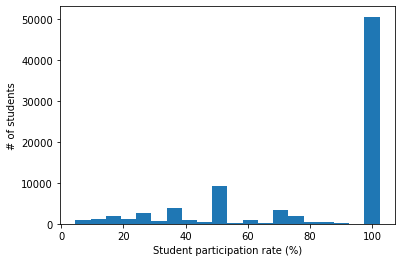

In [87]:
from matplotlib import pyplot as plt

plt.hist(students_info_df.parti_rate.values*100, 20, align='right');
plt.xlabel('Student participation rate (%)')
plt.ylabel('# of students')
#plt.ylim([0,700])

plt.show()

In [ ]:
class_info_df